In [1]:
import csv
import os
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt
import requests
import pprint
import json
import glob
import pandas as pd
from requests.adapters import HTTPAdapter
import sys
!{sys.executable} -m pip install python-usda
from usda import UsdaClient
from requests.packages.urllib3.util.retry import Retry
import re
from collections import defaultdict

You are using pip version 18.1, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### USDA API Credential

In [2]:
### USDA Client Key ###
# client = UsdaClient('ohrJBZWi8Ggdf00mMWbax5fTBFc4mRm0i8kFGu6D')
client = UsdaClient('5jy6h1p6kZf5UX6aBXdQr2frrtfvNZKNZrsyxCei')
USDA_API_KEY = '5jy6h1p6kZf5UX6aBXdQr2frrtfvNZKNZrsyxCei'

#### Import and Read Validation Data

In [3]:
validation_set = pd.read_csv('Annual_Data.csv', encoding= 'unicode_escape')  
print("Size of Validation Set: {}".format(len(validation_set.index)))
validation_set

Size of Validation Set: 30120


/Users/irisliu/.pyenv/versions/3.6.8/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (32,33,34,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Menu_Item_ID,Restaurant,Food_Category,Item_Name_2018,Item_Description_2018,Serving_Size_2018,Serving_Size_text_2018,Serving_Size_Unit_2018,Serving_Size_household_2018,Calories_2018,...,Sodium_text_2018,Potassium_text_2018,Carbohydrates_text_2018,Protein_text_2018,Sugar_text_2018,Dietary_Fiber_text_2018,Kids_Meal_2018,Limited_Time_Offer_2018,Regional_2018,Shareable_2018
0,100054,Qdoba,Entrees,Burrito Bowl,"Burrito Bowl, Burritos & More, Vegetarian Eats...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,100057,Qdoba,Sandwiches,Quesadilla Kids Meal,"Quesadilla Kids Meal w/ Quesadilla, Applesauce...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2,100060,Qdoba,Sandwiches,Burrito,"Burrito, Burritos & More, Vegetarian Eats; Cho...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,100073,Qdoba,Toppings & Ingredients,"Flour Tortilla, 12.5 in","Flour Tortilla, 12.5 in, Ingredients for Entrees",102.0,NaN,g,NaN,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,10012,Applebee's,Soup,French Onion Soup,"French Onion Soup w/ Melted Cheese & Croutons,...",NaN,NaN,NaN,NaN,380.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30115,99835,Pizza Hut,Pizza,"Buffalo Chicken Pizza on Hand Tossed Crust, La...","Buffalo Chicken Pizza w/ Buffalo Pizza Sauce, ...",NaN,NaN,NaN,1 Slice,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
30116,99966,Popeyes,Entrees,Tenders Family Meals,"Tenders Family Meals w/ Handcrafted Tenders, S...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
30117,99968,Popeyes,Entrees,3 Cajun Fish Filets,"3 Cajun Fish Filets, Seafood, Not Available At...",NaN,NaN,NaN,3 Pieces,380.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
30118,99969,Popeyes,Entrees,Fish & Popcorn Shrimp,"Fish & Popcorn Shrimp w/ Side & Biscuit, Seafood",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


## 1. Clean Dataset by filtering drink items

In [ ]:
drink_corpus = ['wine', 'white', 'rosé', 'drink', 'drinks', 'red', 'cocktail', 'martinis', 'sparkling', 
                'cocktails', 'beverages', 'bptmargaritas', 'beer', 'sangria', 'tequila', 'anejo', 
               'mezcal', 'reposado', 'blanco / Plata', 'Aguas Frescas', 'bloodymary&mimosacart', 
                'seasonalspritz', 'aguafrescas', 'californiachardonnay', 'Italian White', 'French White', 
                'Cabernet', 'Italian Red', 'California Merlot', 'Pinot Noir', 'Bordeaux Red', 'White Wine', 
                'Red Wine', 'Rose / Sparkling', 'On Tap', 'Proudly Serving Forster & Burnett','Bubbles','Margaritas','Chardonnay','Vinos','Pinot Grigio','Sauvignon Blanc','Rose','Cócteles','Malbec','Cervezas','Bottled','Draft','Wines By the Glass','Margarita Pitchers','Tequila Shots',
                'Draught Beer', 'Old World Reds', 'Bottles & Cans', 'Eclectic Reds - New World', 'Cabernet Sauvignon', 'Bordeaux Blend', 'Prosecco', 'Champagne'
                'soda', 'coffee', 'Iced Tea', 'Aquas Frescas', 'Xv Coffee', 'merlot', 'coffee', 'Juice, Coffee and Tea'
               ]
# drink_corpus = pd.read_csv('drinks_corpus.csv', delimiter=',', sep='\t', header=None)

def is_drink_item(item):
    item = str(item)
    clean_food_string = re.sub('\W+','', item.lower())
    for key in drink_corpus:
        clean_key = re.sub('\W+','', key.lower())
        if clean_food_string.find(clean_key) != -1 and clean_food_string == clean_key:
#             print('>>>>Filtered...: ', item)
            return True
    return False
        

## 2. Search for food items' nutrition using USDA API

In [ ]:
def usda_food_search(item):
    url = 'https://api.nal.usda.gov/fdc/v1/foods/search?api_key='+ USDA_API_KEY
    # USDA_API_KEY
    headers={'Content-type':'application/json', 'Accept':'application/json'}
    data = {
      "query": item,
      "pageSize": 25,
      "sortBy": "dataType.keyword",
      "sortOrder": "asc"
    }
    r = requests.post(url=url, json=data, headers=headers)
    if r.status_code == 200:
        result = r.json()
        return result
    return None
        

In [ ]:
food_dict = defaultdict(list)
menu_files_folder_name = 'validation_nutrient_report_Dec_15' #### Change the name here for the nutrient report from USDA ####
if not os.path.exists(menu_files_folder_name):
    os.makedirs(menu_files_folder_name)
    
def scan_food_item_from_main_section(validation_set):
    food_items = validation_set[' Item_Name_2018']
    location_names = validation_set['Restaurant']
    for index, food_item in enumerate(food_items):
        if not is_drink_item(food_item):
            nut={}
            nut1={}
            count=0
            d={}
            main_nut=["energy","protein","total lipid (fat)","carbohydrate","fiber","sodium","cholesterol"]

            #To get the nutrient decomposition for each.
            nut = {"energy":0,"protein":0,"total lipid (fat)":0,"carbohydrate":0,"fiber":0,"sodium":0,"cholesterol":0}
            try:
                food_item =  re.sub('[^A-Za-z]+', ' ', food_item)
                location_name = location_names[index]
                saved_food_item_filepath = os.path.join(menu_files_folder_name + '/nutrient_'+ location_name + '_' + food_item.replace(" ", "_") + '.json')
                if not os.path.exists(saved_food_item_filepath):
                    report = usda_food_search(food_item)
                    if report:
                        with open(saved_food_item_filepath, 'w+') as file:
                            json.dump(report, file)

            except:
                continue
            

scan_food_item_from_main_section(validation_set)

## 3. Perform Nutrition Analysis & Save to CSV
Calculate the energy and nutrition values of each matched food items. Then, output the USDA nutrition values as well as the ground truth nutritional values of the food items to USDA. Encountered NaN values in ground truths are eliminated in the process.

In [4]:

# Load all nutrient report
nutrient_reports = []
nutrient_report_names = ['validation_nutrient_report_Dec_15'] #### Change the name here for the nutrient report from USDA ####
for files in nutrient_report_names:
    nutrient_reports.extend(glob.glob(os.path.join(files, "*.json")))


# Setup CSV
validation_analysis="./validation_analysis_Dec_15.csv" #### FINAL CSV filename here ####
csvfile = open(validation_analysis,'w+')
validation_analysis_f = csv.writer(csvfile)
validation_analysis_f.writerow(["Restaurant Name","Original food Item", "Matched food Item", 
                                "Match Score","Energy (KCAL)","Protein (G)","Total lipid(fat) (G)",
                                "Carbohydrate (G)","Fiber (G)","Sodium (MG)","Cholesterol (MG)",
                                "GT - Energy (KCAL)", "GT - Protein (G)","GT - Total lipid(fat) (G)",
                                "GT - Carbohydrate (G)"])

# Average all nutrient content 
food_score_threshold = 25

for report in nutrient_reports:
    energy, protein, total_lipid, carbohydrate, fiber, sodium, cholesterol = [],[],[],[],[],[],[] 
    with open(str(report)) as input_file:
        filename = report.split('/')[-1].split('_')
        location_name = filename[1]
        food = report.split('/')[-1].split('.json')[0].split(location_name)[-1].replace('_', ' ').lstrip()
        data = json.load(input_file)
        
        if 'foods' in data:
            food_benchmark = data["foods"]
            match_food_items = []
            pos_correlated_food_search = []
            match_food_score = 0
            for food_item in food_benchmark:
                pos_correlated_food_search.append(False)
                match_food_items.append(food_item['description'])
                match_food_score += food_item['score']
                food_nutrients = food_item['foodNutrients']

                # Calculate food value if matched food item is positively correlated to original food item
                if food_nutrients and match_food_score > food_score_threshold:
                    pos_correlated_food_search.append(True)
                    for food_nutrient in food_nutrients:
                        if food_nutrient['nutrientId'] == 1003:
                            protein.append(food_nutrient['value'])
                        if food_nutrient['nutrientId'] == 1004:
                            total_lipid.append(food_nutrient['value'])
                        if food_nutrient['nutrientId'] == 1008:
                            energy.append(food_nutrient['value'])
                        if food_nutrient['nutrientId'] == 1005:
                            carbohydrate.append(food_nutrient['value'])
                        if food_nutrient['nutrientId'] == 1079:
                            fiber.append(food_nutrient['value'])
                        if food_nutrient['nutrientId'] == 1093:
                            sodium.append(food_nutrient['value'])
                        if food_nutrient['nutrientId'] == 1253:
                            cholesterol.append(food_nutrient['value'])
    
    # Calculate the average nutrients
    if np.array(pos_correlated_food_search).any():
        average_protein = sum(protein) / len(protein) if len(protein) > 0 else 0
        average_total_lipid = sum(total_lipid) / len(total_lipid) if len(total_lipid) > 0 else 0
        average_energy = sum(energy) / len(energy) if len(energy) > 0 else 0
        average_carbohydrate = sum(carbohydrate) / len(carbohydrate) if len(carbohydrate) > 0 else 0
        average_fiber = sum(fiber) / len(fiber) if len(fiber) > 0 else 0
        average_sodium = sum(sodium) / len(sodium) if len(sodium) > 0 else 0
        average_cholesterol = sum(cholesterol) / len(cholesterol) if len(cholesterol) > 0 else 0
        average_match_food_score = match_food_score / len(match_food_items) * 1.0 if match_food_score != 0 else 0       
        
        valid_food_item = validation_set[' Item_Name_2018'].str.replace(r'[^A-Za-z]+', ' ')
        matched_food_criteria = ((valid_food_item == food) & (validation_set.Restaurant == location_name))
        gt_average_energy = validation_set.loc[matched_food_criteria, 'Calories_2018'].values[0] if validation_set.loc[matched_food_criteria, 'Calories_2018'].values.size > 0 else None
        gt_average_protein = validation_set.loc[matched_food_criteria, 'Protein_2018'].values[0] if validation_set.loc[matched_food_criteria, 'Protein_2018'].values.size > 0 else None
        gt_average_total_lipid = validation_set.loc[matched_food_criteria, 'Total_Fat_2018'].values[0] if validation_set.loc[matched_food_criteria, 'Total_Fat_2018'].values.size > 0 else None
        gt_average_carbohydrate = validation_set.loc[matched_food_criteria, 'Carbohydrates_2018'].values[0] if validation_set.loc[matched_food_criteria, 'Carbohydrates_2018'].values.size > 0 else None
        
        validation_analysis_f.writerow([location_name, food, match_food_items, average_match_food_score, average_energy, 
                                  average_protein, average_total_lipid, average_carbohydrate, average_fiber, 
                                  average_sodium, average_cholesterol, gt_average_energy, gt_average_protein, 
                                  gt_average_total_lipid, gt_average_carbohydrate])



In [5]:
nutrient_pd = pd.read_csv(validation_analysis) 
# drop Nan values
nutrient_plt = nutrient_pd.replace(np.nan, '', regex=True).dropna()
print('This table contains: {} rows x {} cols.'.format(nutrient_plt.shape[0], nutrient_plt.shape[1]))
nutrient_plt.head(50)

This table contains: 15419 rows x 15 cols.


,Restaurant Name,Original food Item,Matched food Item,Match Score,Energy (KCAL),Protein (G),Total lipid(fat) (G),Carbohydrate (G),Fiber (G),Sodium (MG),Cholesterol (MG),GT - Energy (KCAL),GT - Protein (G),GT - Total lipid(fat) (G),GT - Carbohydrate (G)
0,Chili's,Classic Nachos Fajita Chicken,"['CLASSIC FAJITA SIMMER SAUCE, CLASSIC FAJITA'...",61.966458,119.541667,10.335000,2.780000,11.904167,0.861905,2423.750000,32.095238,1480,99,95,57
1,Wawa,Cinnamon Sugar Twist FL,"['CINNAMON & SUGAR TWISTED PRETZELS, CINNAMON ...",49.946345,376.080000,4.066800,9.750800,243.879600,2.306250,2314.240000,19.937500,340,7,14,47
2,Dunkin' Donuts,Original Kolache,"['SAUSAGE KOLACHE', 'KOLACHES SMOKED SAUSAGE',...",-224.091143,294.400000,9.116000,14.700000,32.580000,1.420000,722.000000,27.800000,180,10,9,20
3,Tim Hortons,Oatmeal Maple Regular,"['INSTANT REGULAR OATMEAL, REGULAR', 'REGULAR ...",83.731024,357.360000,11.743600,7.616400,62.939200,8.568000,292.640000,5.363636,220,5,2.5,49
4,LongHorn Steakhouse,Raspberry Iced Tea,"['RASPBERRY ICED TEA, RASPBERRY', 'RASPBERRY I...",143.203472,81.600000,0.000000,0.000000,21.019000,0.000000,10.450000,0.000000,50,0,0,13
5,The Capital Grille,Adults Only Arnold Palmer,"['NATURAL ENERGY ARNOLD PALMER', 'ARIZONA, ARN...",-10.910259,283.272727,2.525909,9.127273,50.837273,0.895455,165.681818,1.318182,180,15,0,110
6,BJ's Restaurant & Brewhouse,EXXXXtra Hot Buffalo,"['HOT BUFFALO FLAVORED POPCORN, HOT BUFFALO', ...",26.389151,203.142857,7.412381,13.917000,14.262000,2.869231,65179.047619,41.769231,30,1,1,6
7,Dunkin' Donuts,Winter White Chocolate Swirl Hot Latte w Whole...,"['WHITE & MILK CHOCOLATE SWIRL', 'SIMPLY SMALL...",118.936525,338.375000,5.343333,19.121250,38.022083,2.230435,180.652174,10.136364,230,8,6,36
8,Wawa,Hot Vanilla Latte oz,"['VANILLA LATTE COFFEE, VANILLA LATTE', 'VANIL...",68.871408,249.583333,11.302500,9.553750,32.370000,1.900000,250.458333,26.041667,50,0,0,14
9,Dunkin' Donuts,Peppermint Mocha Swirl Iced Coffee w Cream Large,"['PEPPERMINT MOCHA COFFEE CREAMER, PEPPERMINT ...",379.695392,268.333333,3.507600,10.064800,40.725200,0.771429,90.840000,8.458333,370,4,12,63


## 4. Ground Truth Analysis

#### 4.1 Correlation Matrix

                           Energy (KCAL)  Protein (G)  Total lipid(fat) (G)  \
Energy (KCAL)                   1.000000     0.428040              0.763030   
Protein (G)                     0.428040     1.000000              0.326153   
Total lipid(fat) (G)            0.763030     0.326153              1.000000   
Carbohydrate (G)                0.733150     0.094431              0.182194   
GT - Energy (KCAL)              0.145759     0.191536              0.106546   
GT - Protein (G)                0.044951     0.296643              0.055081   
GT - Total lipid(fat) (G)       0.152124     0.216596              0.186889   
GT - Carbohydrate (G)           0.130163     0.043983              0.002520   

                           Carbohydrate (G)  GT - Energy (KCAL)  \
Energy (KCAL)                      0.733150            0.145759   
Protein (G)                        0.094431            0.191536   
Total lipid(fat) (G)               0.182194            0.106546   
Carbohydrate (G)    

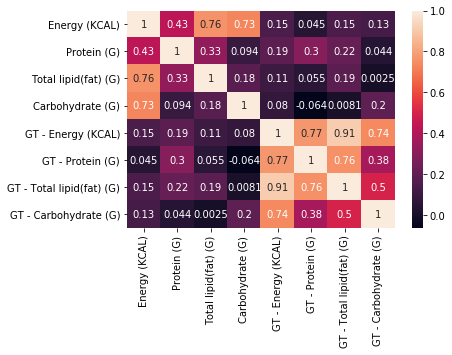

In [18]:
import seaborn as sn
import matplotlib.pyplot as plt

ground_truth_df = pd.DataFrame(nutrient_pd, columns=['Energy (KCAL)', 'Protein (G)', 'Total lipid(fat) (G)', 'Carbohydrate (G)', 'GT - Energy (KCAL)', 'GT - Protein (G)', 'GT - Total lipid(fat) (G)', 'GT - Carbohydrate (G)'])
corrMatrix = ground_truth_df.corr()
print(corrMatrix)

sn.heatmap(corrMatrix, annot=True)
plt.show()


#### 4.2 Density Distribution & Scatter plot 
Density Distribution generate kernel density estimate using gaussian kernels

#### Average Energy (Kcal)

/Users/irisliu/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Scatter Plot of food items by Average Calories')

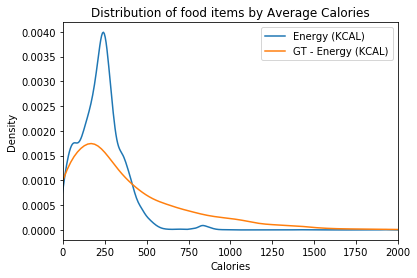

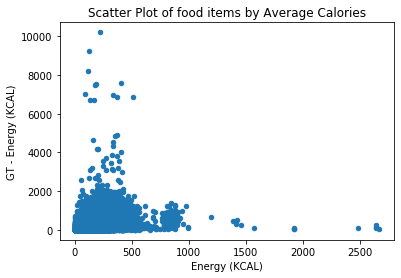

In [80]:
calories_plt = nutrient_plt[["Energy (KCAL)", "GT - Energy (KCAL)"]]

# remove nan value
nan_value = float("NaN")
calories_plt.replace("", nan_value, inplace=True)
calories_plt.dropna(subset = ['GT - Energy (KCAL)'], inplace=True)
calories_plt['Energy (KCAL)'].astype(float)
calories_plt['GT - Energy (KCAL)'].astype(float)

ax = calories_plt.plot.kde()
plt.xlim([0,2000])  
plt.title('Distribution of food items by Average Calories')
plt.xlabel('Calories')
plt.ylabel('Density')

ax2 = calories_plt.plot.scatter(x='Energy (KCAL)', y='GT - Energy (KCAL)')
plt.title('Scatter Plot of food items by Average Calories')


#### Carbonhydrates (g)

/Users/irisliu/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Scatter Plot of food items by Carbonhydrates (g)')

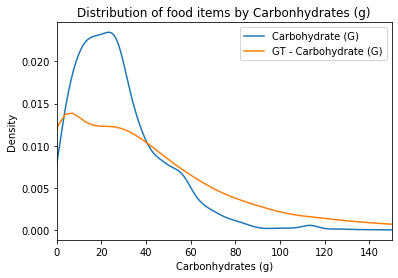

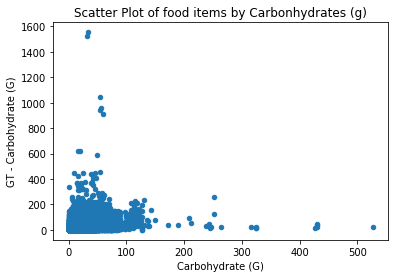

In [91]:
carb_plt = nutrient_plt[["Carbohydrate (G)", "GT - Carbohydrate (G)"]]

# remove nan value
nan_value = float("NaN")
carb_plt.replace("", nan_value, inplace=True)
carb_plt.dropna(subset = ["GT - Carbohydrate (G)"], inplace=True)
carb_plt["Carbohydrate (G)"].astype(float)
carb_plt["GT - Carbohydrate (G)"].astype(float)

ax = carb_plt.plot.kde()
plt.xlim([0,150])  
plt.title('Distribution of food items by Carbonhydrates (g)')
plt.xlabel('Carbonhydrates (g)')
plt.ylabel('Density')

ax2 = carb_plt.plot.scatter(x="Carbohydrate (G)", y="GT - Carbohydrate (G)")
plt.title('Scatter Plot of food items by Carbonhydrates (g)')

#### Lipid (g)

/Users/irisliu/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Scatter Plot of food items by Lipid (g)')

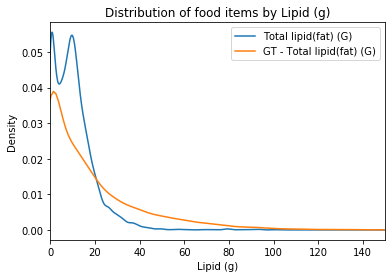

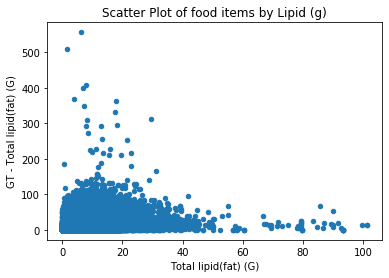

In [92]:
lipid_plt = nutrient_plt[["Total lipid(fat) (G)", "GT - Total lipid(fat) (G)"]]

# remove nan value
nan_value = float("NaN")
lipid_plt.replace("", nan_value, inplace=True)
lipid_plt.dropna(subset = ["GT - Total lipid(fat) (G)"], inplace=True)
lipid_plt["Total lipid(fat) (G)"].astype(float)
lipid_plt["GT - Total lipid(fat) (G)"].astype(float)

ax = lipid_plt.plot.kde()
plt.xlim([0,150])  
plt.title('Distribution of food items by Lipid (g)')
plt.xlabel('Lipid (g)')
plt.ylabel('Density')

ax2 = lipid_plt.plot.scatter(x="Total lipid(fat) (G)", y="GT - Total lipid(fat) (G)")
plt.title('Scatter Plot of food items by Lipid (g)')

#### Protein (g)

/Users/irisliu/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Scatter Plot of food items by Protein (g)')

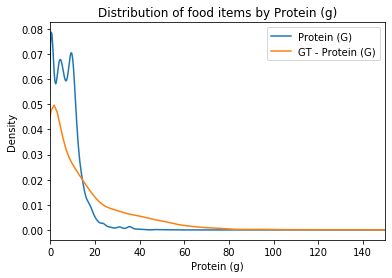

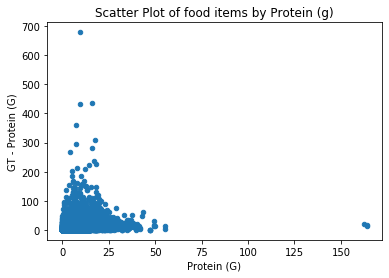

In [93]:
protein_plt = nutrient_plt[["Protein (G)", "GT - Protein (G)"]]

# remove nan value
nan_value = float("NaN")
protein_plt.replace("", nan_value, inplace=True)
protein_plt.dropna(subset = ["GT - Protein (G)"], inplace=True)
protein_plt["Protein (G)"].astype(float)
protein_plt["GT - Protein (G)"].astype(float)

ax = protein_plt.plot.kde()
plt.xlim([0,150])  
plt.title('Distribution of food items by Protein (g)')
plt.xlabel('Protein (g)')
plt.ylabel('Density')
ax2 = protein_plt.plot.scatter(x="Protein (G)", y="GT - Protein (G)")
plt.title('Scatter Plot of food items by Protein (g)')